![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/80.0.Legal_Contract_Understanding.ipynb)

#🔎 PROCESSING A LEGAL AGREEMENT

##📚 Processing a Legal document using Spark NLP

Here is an illustration of a usecase we developed using a legal document to walk through the process step by step, from dividing a paragraph to recognising the relationships in the document, and demonstrate how we may get the desired results.

#🎬 Installation

In [1]:
! pip install -q johnsnowlabs

##🔗 Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

##🔗 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

#📌 Starting

In [ ]:
spark = nlp.start()

## Loading the data

In [6]:
import requests
URL = "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/credit_agreement_2.txt"
response = requests.get(URL)

credit_agreement = response.content.decode('utf-8')

In [ ]:
print(credit_agreement)

In [8]:
#fit: trains, configures and prepares the pipeline for inference. 
sdf = spark.createDataFrame([[ credit_agreement ]]).toDF("text")


In [ ]:
sdf.select('text').show(truncate=False)

**We were successfully able to load the document to the notebook, Now let's apply the magic of Spark NLP and see what all we can achieve.**

# Document Classification

####✔️ Let's check if the document is a Credit Agreement or not using Document Cassification.

**For more information look in the models hub page of the model.**
https://nlp.johnsnowlabs.com/2022/11/24/legclf_credit_agreement_bert_en.html

In [10]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
  
embeddings = nlp.BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "en")\
    .setInputCols("document")\
    .setOutputCol("sentence_embeddings")
    
doc_classifier = legal.ClassifierDLModel.pretrained("legclf_credit_agreement_bert", "en", "legal/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("category")
    
nlpPipeline = nlp.Pipeline(stages=[
    document_assembler, 
    embeddings,
    doc_classifier])


model = nlpPipeline.fit(sdf)

result = model.transform(sdf)
result.select('category.result').show()

sent_bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
legclf_credit_agreement_bert download started this may take some time.
[OK!]
+------------------+
|            result|
+------------------+
|[credit-agreement]|
+------------------+



#🔎 Clause Classification
Since clauses consist of more than 1 sentence, the best way to carry out Clause Classification is to split the document in paragraphs, and detect them separately.

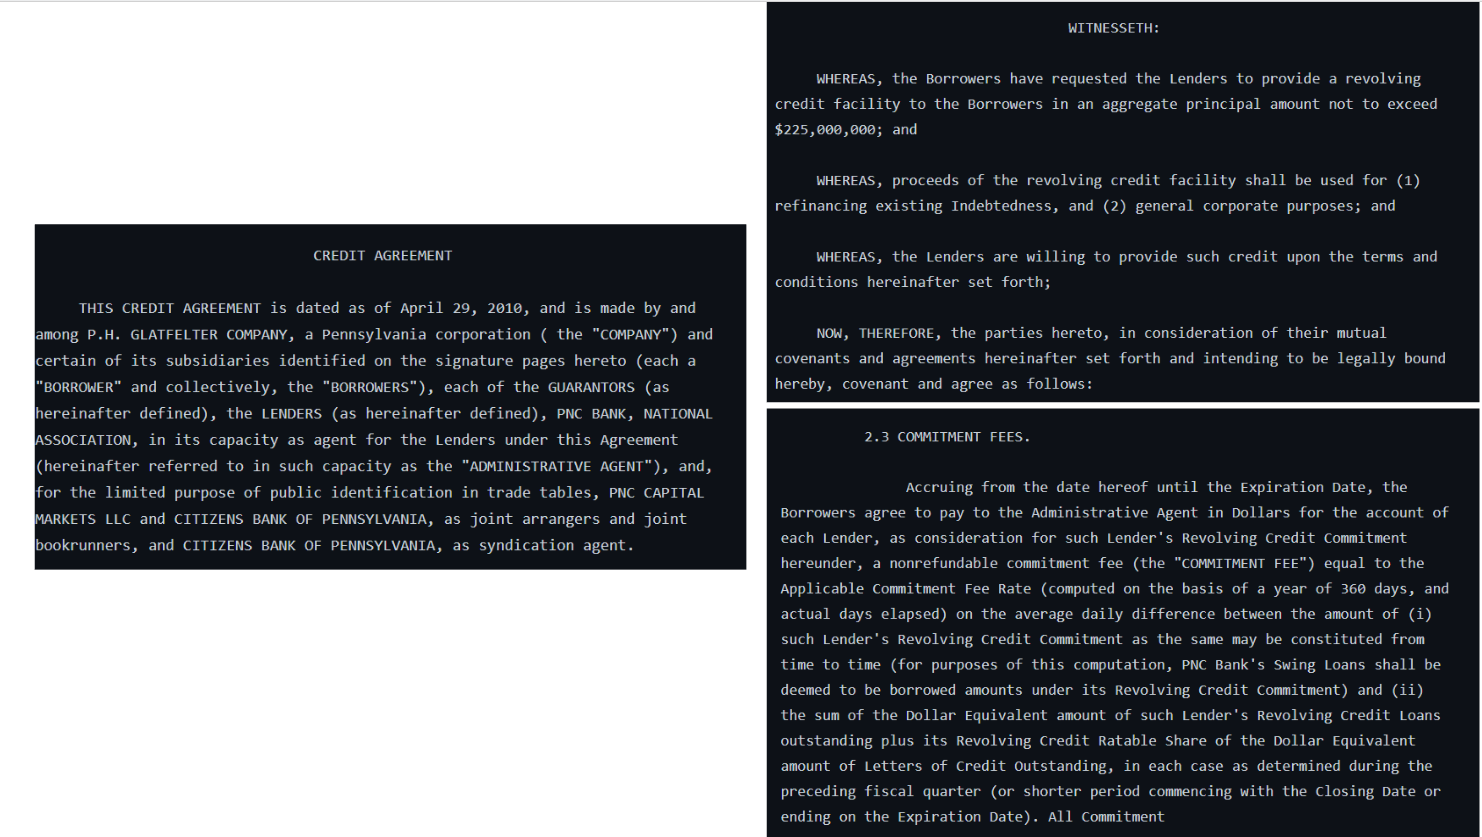

📚
In Legal NLP we have more than **575 classifiers** which you can use to detect specific clauses in your documents **using a paragraph splitting**. You can find them in [Models Hub](https://nlp.johnsnowlabs.com/models?edition=Legal+NLP&q=Clause).

```
...
- legclf_indemnification_clause
- legclf_insolvency_clause
- legclf_whereas_clause
- legclf_indebtedness_clause
- legclf_in_witness_whereof_clause
- legclf_illegality_clause
- legclf_indebtedness_clause
- legclf_guarantee_clause
- legclf_increased_costs_clause
- legclf_insurance_clause
- legclf_intellectual_property_clause
- legclf_interest_clause
- legclf_jurisdiction_clause
- legclf_letters_of_credit_clause
- legclf_liability_clause
...
```
📚All of these models are **Binary Classifiers**, which means they will return True or False, or better to say ,the name of the class (for example, `whereas`) if the class `whereas` is found, or `other` if it's not a `whereas` clause, but something else.

**CLARIFICATION**: We did not want to return `True` or `False` because these models can all be stuck one after another, so in case a clause triggers some classes at the same time (clauses are very often not disjoint) we could be getting several `True`, which is less informative than retrieving directly the type of the classes detected `interest` and `increased_costs` for example.


##❓ Example of how splitting affects paragraph classification

📜Explanation:
- `.setCustomBounds(["\n\n"])` sets an array of regular expression(s) to tell the annotator how to split the document. (**Here we are splitting by paragraph.**)
- `.setUseCustomBoundsOnly(True)` the default behaviour of TextSplitter is Text Splitting, so we set to ignore the default regex ('\n', ...).
- `.setExplodeSentences(True)` creates one new row in the dataframe per split.

In [11]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

text_splitter = legal.TextSplitter() \
    .setInputCols(["document"]) \
    .setOutputCol("paragraphs")\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    text_splitter])

In [12]:
sdf = spark.createDataFrame([[ credit_agreement ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

lp = nlp.LightPipeline(fit)

res = lp.annotate(credit_agreement)
paragraphs = res['paragraphs']
paragraphs = [p for p in paragraphs if p.strip() != ''] # We remove empty pages

In [13]:
paragraphs

['Exhibit: 10.1',
 'TWELFTH AMENDMENT TO AMENDED AND\n                            RESTATED CREDIT AGREEMENT',
 'THIS TWELFTH AMENDMENT TO AMENDED AND RESTATED CREDIT\nAGREEMENT ("Twelfth Amendment") is made as of the 27th day of December, 2007, by\nand between CULP, INC., a North Carolina corporation (together with its\nsuccessors and permitted assigns, the "Borrower"), and WACHOVIA BANK, NATIONAL\nASSOCIATION (formerly, Wachovia Bank, N.A.), a national banking association, as\nAgent and as a Bank (together with its endorsees, successors and assigns, the\n"Bank").',
 'BACKGROUND\n                                   ----------',
 'The Borrower and the Bank entered into an Amended and Restated\nCredit Agreement, dated as of August 23, 2002, as amended by Second Amendment to\nAmended and Restated Credit Agreement (the "Second Amendment"), dated as of June\n3, 2003, by Third Amendment to Amended and Restated Credit Agreement (the "Third\nAmendment"), dated as of August 23, 2004, by Fourth A

####✔️ **Let's try to identify the introductory clauses from the Credit agreement document.**

In [14]:
embeddings = nlp.BertSentenceEmbeddings.pretrained("sent_bert_base_cased", "en")\
    .setInputCols("document")\
    .setOutputCol("sentence_embeddings")
    
doc_classifier = legal.ClassifierDLModel.pretrained("legclf_introduction_clause", "en", "legal/models")\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("category")

nlpPipeline = nlp.Pipeline(stages=[
    document_assembler, 
    embeddings,
    doc_classifier])

texts = [[i] for i in paragraphs]
df = spark.createDataFrame(texts).toDF("text")

model = nlpPipeline.fit(df)

result = model.transform(df)
result.select('category.result').show()

sent_bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]
legclf_introduction_clause download started this may take some time.
[OK!]
+--------------+
|        result|
+--------------+
|       [other]|
|[introduction]|
|[introduction]|
|[introduction]|
|[introduction]|
|       [other]|
|       [other]|
|       [other]|
|       [other]|
|       [other]|
|       [other]|
|[introduction]|
|       [other]|
|       [other]|
|       [other]|
|       [other]|
|       [other]|
|[introduction]|
|       [other]|
|       [other]|
+--------------+
only showing top 20 rows



####✔️ **Let's take a look at the first clause identified as 'introductory'**

In [15]:
credit_agreement = texts[2]

In [16]:
credit_agreement

['THIS TWELFTH AMENDMENT TO AMENDED AND RESTATED CREDIT\nAGREEMENT ("Twelfth Amendment") is made as of the 27th day of December, 2007, by\nand between CULP, INC., a North Carolina corporation (together with its\nsuccessors and permitted assigns, the "Borrower"), and WACHOVIA BANK, NATIONAL\nASSOCIATION (formerly, Wachovia Bank, N.A.), a national banking association, as\nAgent and as a Bank (together with its endorsees, successors and assigns, the\n"Bank").']

In [17]:
import re
credit_agreement = re.sub(r'\s+', ' ', credit_agreement[0])
credit_agreement

'THIS TWELFTH AMENDMENT TO AMENDED AND RESTATED CREDIT AGREEMENT ("Twelfth Amendment") is made as of the 27th day of December, 2007, by and between CULP, INC., a North Carolina corporation (together with its successors and permitted assigns, the "Borrower"), and WACHOVIA BANK, NATIONAL ASSOCIATION (formerly, Wachovia Bank, N.A.), a national banking association, as Agent and as a Bank (together with its endorsees, successors and assigns, the "Bank").'

**Let's use one of the clauses that have been identified as `introductory` for detecting the entities and then mapping the relations between them.**

# Entity Extraction with NER

**In 'introductory' clauses, we can see entities such as:**
- Contract Types
- Parties in an agreement
- Effective Dates
- etc

**Let's extract them using Name Entity Recognition (NER)**

####✔️ Let's find the **entities** from the `credit-agreement` paragraph:

**For more information look at the models hub page of the model**: https://nlp.johnsnowlabs.com/2022/12/01/legner_contract_doc_parties_md_en.html

In [18]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
        .setInputCols("sentence", "token") \
        .setOutputCol("embeddings")\

ner_model = legal.NerModel.pretrained('legner_contract_doc_parties_lg', 'en', 'legal/models')\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlpPipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

sentence_detector_dl download started this may take some time.
Approximate size to download 514.9 KB
[OK!]
roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties_lg download started this may take some time.
[OK!]


In [19]:
sdf = spark.createDataFrame([[credit_agreement]]).toDF("text")

fit = nlpPipeline.fit(sdf)

lp = nlp.LightPipeline(fit)

In [20]:
res = lp.fullAnnotate(credit_agreement)

####✔️ **Visualizing the results**

In [21]:

from johnsnowlabs import viz

ner_viz = viz.NerVisualizer()

ner_viz.display(res[0], label_col='ner_chunk')

####✔️ **Good! We have extracted the most important chunks of information from the credit agreement**...
...by using a pretrained **NER** model.

####✔️ **What if we don't have pretrained models for the specific entities I want?**
You can still use **Zero-shot NER**, just providing a series of questions.

In [22]:

documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

textSplitter = legal.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

sparktokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

zero_shot_ner = legal.ZeroShotNerModel.pretrained("legner_roberta_zeroshot", "en", "legal/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("zero_shot_ner")\
    .setEntityDefinitions(
        {
            "FORMER_NAME": ['The company was formerly known as?'],
            "LOCATION": ["From which state is the company?"],
            "AMENDMENT": ['What type of amendment is it?']
        })


nerconverter = legal.NerConverterInternal()\
  .setInputCols(["sentence", "token", "zero_shot_ner"])\
  .setOutputCol("ner_chunk")\
  .setGreedyMode(True)

pipeline =  nlp.Pipeline(stages=[
  documentAssembler,
  textSplitter,
  sparktokenizer,
  zero_shot_ner,
  nerconverter
    ]
)

legner_roberta_zeroshot download started this may take some time.
[OK!]


In [23]:
from pyspark.sql.types import StructType,StructField, StringType

p_model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))
res = p_model.transform(spark.createDataFrame([credit_agreement], StringType()).toDF("text"))

In [24]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result, res.ner_chunk.begin, res.ner_chunk.end, res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['0']").alias("chunk"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)
     

+-------------------------------------+-----------+
|chunk                                |ner_label  |
+-------------------------------------+-----------+
|AMENDED AND RESTATED CREDIT AGREEMENT|AMENDMENT  |
|Twelfth Amendment                    |AMENDMENT  |
|North Carolina                       |LOCATION   |
|Wachovia Bank                        |FORMER_NAME|
+-------------------------------------+-----------+



In [25]:
lp = nlp.LightPipeline(p_model)

# from sparknlp_display import NerVisualizer

visualiser = nlp.viz.NerVisualizer()
lp_res_1 = lp.fullAnnotate(credit_agreement)
visualiser.display(lp_res_1[0], label_col='ner_chunk', document_col='document')

This is just an example, you can always tweak the questions and see the magic of zero shot NER!


# Relation Extraction

####✔️ Let's map the entities extracted in the "Names of the parties / Introductory" clause using `relations`.

**For more information look at the models hub page of the model**: https://nlp.johnsnowlabs.com/2022/08/12/legre_contract_doc_parties_en_3_2.html

In [53]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

textSplitter = legal.TextSplitter()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
        .setInputCols("sentence", "token") \
        .setOutputCol("embeddings")\

ner_model = legal.NerModel.pretrained('legner_contract_doc_parties_lg', 'en', 'legal/models')\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = legal.NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pos_tagger = nlp.PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentence", "token"])\
    .setOutputCol("pos_tags")
    
dependency_parser = nlp.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentence", "pos_tags", "token"])\
    .setOutputCol("dependencies")

re_ner_chunk_filter = legal.RENerChunksFilter() \
    .setInputCols(["ner_chunk", "dependencies"])\
    .setOutputCol("re_ner_chunks")\
    .setRelationPairs(["PARTY-ALIAS"])\
    .setMaxSyntacticDistance(7)

reDL = legal.RelationExtractionDLModel().pretrained('legre_contract_doc_parties_lg', 'en', 'legal/models')\
    .setPredictionThreshold(0.8)\
    .setInputCols(["re_ner_chunks", "sentence"])\
    .setOutputCol("relations")   

nlpPipeline = nlp.Pipeline(stages=[
    documentAssembler,
    textSplitter,
    tokenizer,
    embeddings,
    ner_model,
    ner_converter,
    zero_shot_ner,
    pos_tagger,
    dependency_parser,
    re_ner_chunk_filter,
    reDL
])

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties_lg download started this may take some time.
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.5 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.7 MB
[OK!]
legre_contract_doc_parties_lg download started this may take some time.
[OK!]


In [54]:
empty_df = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_df)

light_model = nlp.LightPipeline(model)


In [55]:
# Create Generic Function to Show Relations in Dataframe

import pandas as pd
def get_relations_df (results, col='relations'):
    rel_pairs=[]
    for i in range(len(results)):
        for rel in results[i][col]:
            rel_pairs.append((
              rel.result, 
              rel.metadata['entity1'], 
              rel.metadata['entity1_begin'],
              rel.metadata['entity1_end'],
              rel.metadata['chunk1'], 
              rel.metadata['entity2'],
              rel.metadata['entity2_begin'],
              rel.metadata['entity2_end'],
              rel.metadata['chunk2'], 
              rel.metadata['confidence']
          ))
    rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])
    return rel_df

In [56]:
credit_agreement

'THIS TWELFTH AMENDMENT TO AMENDED AND RESTATED CREDIT AGREEMENT ("Twelfth Amendment") is made as of the 27th day of December, 2007, by and between CULP, INC., a North Carolina corporation (together with its successors and permitted assigns, the "Borrower"), and WACHOVIA BANK, NATIONAL ASSOCIATION (formerly, Wachovia Bank, N.A.), a national banking association, as Agent and as a Bank (together with its endorsees, successors and assigns, the "Bank").'

In [57]:
result = light_model.fullAnnotate(credit_agreement)

rel_df = get_relations_df(result)

In [58]:
rel_df[(rel_df["relation"] != "no_rel") & (rel_df["relation"] != "other")]

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,has_alias,PARTY,147,155,"CULP, INC",ALIAS,246,253,Borrower,0.995989
1,has_alias,PARTY,262,296,"WACHOVIA BANK, NATIONAL ASSOCIATION",ALIAS,309,326,"Wachovia Bank, N.A",0.9998852
2,has_alias,PARTY,262,296,"WACHOVIA BANK, NATIONAL ASSOCIATION",ALIAS,366,370,Agent,0.99796677
3,has_alias,PARTY,262,296,"WACHOVIA BANK, NATIONAL ASSOCIATION",ALIAS,381,384,Bank,0.9997069


####✔️ **Visualizing the relations!**

In [59]:
# from sparknlp_display import RelationExtractionVisualizer

re_vis = nlp.viz.RelationExtractionVisualizer()

re_vis.display(result = result[0],
           relation_col = "relations",
           document_col = "document",
           exclude_relations = ["no_rel","other"],
           show_relations=True
           )

# **Let's build a graph from the extracted relations**

## Auxiliar functions
For visualization purposes

In [60]:
import plotly.graph_objects as go
import random

def get_nodes_from_graph(graph, pos, node_color):
  """Extracts the nodes from a networkX dataframe in Plotly Scatterplot format"""
  node_x = []
  node_y = []
  texts = []
  hovers = []
  for node in graph.nodes():
    entity = graph.nodes[node]['attr_dict']['entity']
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    texts.append(node)
    hovers.append(entity)

  node_trace = go.Scatter(
    x=node_x, y=node_y, text=texts, hovertext=hovers,
    mode='markers+text',
    hoverinfo='text',
    marker=dict(
        color=node_color,
        size=40,
        line_width=2))
  
  return node_trace


def get_edges_from_graph(graph, pos, edge_color):
  """Extracts the edges from a networkX dataframe in Plotly Scatterplot format"""
  edge_x = []
  edge_y = []
  hovers = []
  xtext = []
  ytext = []
  for edge in graph.edges():
    relation = graph.edges[edge]['attr_dict']['relation']
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    hovers.append(relation)
    xtext.append((x0+x1)/2)
    ytext.append((y0+y1)/2)

  edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=2, color=edge_color),
    mode='lines')
  
  labels_trace = go.Scatter(x=xtext,y= ytext, mode='text',
                              textfont = {'color': edge_color},
                              marker_size=0.5,
                              text=hovers,
                              textposition='top center',
                              hovertemplate='weight: %{text}<extra></extra>')
  return edge_trace, labels_trace


def show_graph_in_plotly(graph, node_color='white', edge_color='grey'):
  """Shows Plotly graph in Databricks"""
  pos = nx.spring_layout(graph)
  node_trace = get_nodes_from_graph(graph, pos, node_color)
  edge_trace, labels_trace = get_edges_from_graph(graph, pos, edge_color)
  fig = go.Figure(data=[edge_trace, node_trace, labels_trace],
               layout=go.Layout(
                  title='Visualization',
                  titlefont_size=16,                   
                  showlegend=False,
                  width=1600,
                  height=1000,
                  xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                  yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                  )
  fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')) 
  fig.show()

## ✔️ **Inserting Nodes (Tags) and Relations into a Graph**


Now, with entities and Relations connecting them, we can start populating the Graph of the company.

In [73]:
import networkx as nx
G = nx.Graph()

G.clear()
G.nodes()

NodeView(())

In [74]:
DOC_TYPE = next(filter(lambda x: x.metadata['entity']=='DOC', result[0]['ner_chunk'])).result
DOC_TYPE

'AMENDED AND RESTATED CREDIT AGREEMENT'

In [75]:
EFFDATE = next(filter(lambda x: x.metadata['entity']=='EFFDATE', result[0]['ner_chunk'])).result
EFFDATE

'27th day of December, 2007'

In [76]:
G.add_node(DOC_TYPE,  attr_dict={'entity': 'DOC'})
G.add_node(EFFDATE,  attr_dict={'entity': 'EFFDATE'})
G.add_edge(DOC_TYPE, EFFDATE, attr_dict={'relation': "signed_in"})  

In [77]:
for t in rel_df.itertuples():
  relation = t.relation
  
  if relation in ['other', 'no_rel']:
    continue
  
  entity1 = t.entity1
  chunk1 = t.chunk1
  entity2 = t.entity2
  chunk2 = t.chunk2
  G.add_node(chunk1,  attr_dict={'entity': entity1})
  G.add_node(chunk2,  attr_dict={'entity': entity2})
  
  G.add_edge(chunk1, chunk2, attr_dict={'relation': relation.lower()})  
  G.add_edge(chunk1, DOC_TYPE, attr_dict={'relation': 'signed'})
  

In [78]:
show_graph_in_plotly(G)